## 📈 Forecasting SPY Using LSTM

### 🔍 Overview

In this project, we aim to forecast the price movement of **SPY**, an ETF that tracks the performance of the S&P 500 index, one of the most popular ETF that represent top 500 company for the overall US equity market. Accurate forecasting of SPY’s price is of great interest for both institutional and retail investors.

This project uses **deep learning techniques**, specifically **Recurrent Neural Networks (RNN)** with **Long Short-Term Memory (LSTM)** units and an **Attention mechanism**, to model temporal dependencies in historical financial data. These architectures are known for their ability to capture long-range patterns in time-series data, which are crucial in financial forecasting.

---

## 🧠 Why LSTM

- **RNNs** are neural networks designed to handle sequential data. However, standard RNNs struggle with learning long-term dependencies due to vanishing gradients.
- **LSTM** networks address this limitation by introducing memory cells and gating mechanisms, making them well-suited for financial time series data.

---

## 📊 Dataset Information

The dataset used for this project was obtained from the **Alpha Vantage API**, a popular source for real-time and historical financial market data. Specifically, I've downloaded the **daily OHLCV (Open, High, Low, Close, Volume)** data for SPY.

- **Source**: [Alpha Vantage](https://www.alphavantage.co)
- **Frequency**: Daily
- **Features**:
  - `Date`
  - `Open`
  - `High`
  - `Low`
  - `Close`
  - `Volume`

I also added holiday data based on US Market for plotting purpose

Before modeling, we preprocessed the data by:
- Converting dates to `datetime` format
- Normalizing the features using Min-Max Scaling

---

## 🎯 Project Goal

The goal of this project is to **predict the next day’s closing price of SPY** based on a fixed-length sequence of previous days’ data. This is formulated as a **sequence-to-one prediction task**, where the model takes a time window of past data as input and returns a single predicted value.

This project is part of an academic assignment focused on the application of deep learning for time-series forecasting.

---

Cr: [Derrick Vericho](https://github.com/DerrickVericho/Financial-Market/)


## Import Library and Dataset

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
df = pd.read_csv('SPY.csv')
df = df.rename(columns={'Unnamed: 0': 'Date'})
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-02,323.54,324.89,322.53,324.87,59037072.0
1,2020-01-03,321.16,323.64,321.10,322.41,77708081.0
2,2020-01-06,320.49,323.73,320.36,323.64,55596982.0
3,2020-01-07,323.02,323.54,322.24,322.73,40461249.0
4,2020-01-08,322.94,325.78,322.67,324.45,68177241.0


In [3]:
holiday = pd.read_csv('holiday.csv')
holiday = holiday['Date']
holiday.head()

0    1970-01-01
1    2022-01-17
2    2022-02-21
3    2022-04-15
4    2022-05-30
Name: Date, dtype: object

## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1341 non-null   object 
 1   Open    1341 non-null   float64
 2   High    1341 non-null   float64
 3   Low     1341 non-null   float64
 4   Close   1341 non-null   float64
 5   Volume  1341 non-null   float64
dtypes: float64(5), object(1)
memory usage: 63.0+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume
count,1341.000000,1341.000000,1341.000000,1341.000000,1.341000e+03
mean,434.095791,436.793750,431.198257,434.183706,8.071967e+07
std,82.658843,82.528587,82.631787,82.628250,4.152384e+07
min,228.190000,229.680000,218.260000,222.950000,2.604871e+07
25%,383.180000,386.213400,380.480000,383.270000,5.583946e+07
50%,425.910000,428.770000,423.540000,427.100000,7.243750e+07
75%,475.260000,477.030000,473.060000,475.650000,9.267393e+07
max,611.540000,613.230000,609.560000,612.930000,3.896121e+08


We need to change the `date` datatypes into datetime, then we could add DayOfWeek and Month columns as essential feature for modelling

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

Let's try to plot them into candlestick chart and line chart

In [7]:
fig = go.Figure()

# Candlestick (OHLC)
fig.add_trace(go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Price'
))

# Volume
fig.add_trace(go.Bar(
        x=df['Date'],
        y=df['Volume'],
        name='Volume',
        marker_color='darkblue',
        yaxis='y2',
        opacity=0.3
))

# Layout
fig.update_layout(
        title='SPY Candlestick History',
        xaxis=dict(
            type='date',
            tickformat='%b %d %Y',
            rangebreaks=[
                dict(bounds=["sat", "mon"]),
                dict(values=holiday)
            ]
        ),
        yaxis=dict(
            title='Price',
            side='right',
            showgrid=True,
            domain=[0.2, 1]
        ),
        yaxis2=dict(
            title='Volume',
            overlaying='y',
            side='left',
            showgrid=False,
            domain=[0, 0.2]
        ),
        xaxis_rangeslider_visible=False,
        height=800,
        showlegend=False
    )

fig.show()

In [8]:
fig = go.Figure()

        # Create line chart
fig.add_trace(go.Scatter(
    x=df['Date'],
    y=df['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='green')
))

        # Create volume
fig.add_trace(go.Bar(
    x=df['Date'],
    y=df['Volume'],
    name='Volume',
    marker_color='darkblue',
    yaxis='y2',
    opacity=0.3
))

        # Layout
fig.update_layout(
    title='SPY Linechart History',
    xaxis=dict(
        type='date',
        tickformat='%b %d %Y',
        rangebreaks=[
            dict(bounds=["sat", "mon"]),
            dict(values=holiday)
        ]
    ),
    yaxis=dict(
        title='Close Price',
        side='right',
        showgrid=True,
        domain=[0.2, 1]
    ),
    yaxis2=dict(
        title='Volume',
        overlaying='y',
        side='left',
        showgrid=False,
        domain=[0, 0.2]
    ),
    xaxis_rangeslider_visible=False,
    height=900,
    showlegend=False
)


## Preprocessing

In this section, I'll prepare the data before feeding it into the model. The preprocessing steps include:

1. **Cyclic Encoding** for `dayofweek` and `month` features.
2. **Scaling** using `MinMaxScaler` to normalize the numerical features.
3. **Train-Test Split** based on date order — we use the latest 20% of data as the test set.

---

### 📅 1. Cyclic Encoding

Some time-based features are cyclical in nature — for example:
- Monday (0) and Friday (5) are actually next to each other (in Financial market case),
- December (12) and January (1) are also neighbors.

To capture this periodicity, we use **cyclical encoding** by applying sine and cosine transformations.


We apply this to:
- `dayofweek` (values from 0 to 6)
- `month` (values from 1 to 12)

This replaces the original values with two new features: sine and cosine components.

---

### 🔀 2. Time-based Train-Test Split

Instead of random splitting, we sort the data by the `Date` column and split it chronologically:
- The **first 80%** of the data (older dates) goes to the **training set**.
- The **latest 20%** becomes the **test set**.

This setup better simulates real-world scenarios, where we always try to predict the future based on past data.

---

### 🔢 3. Feature Scaling with MinMaxScaler

After encoding, we scale all numerical features using **MinMaxScaler** to bring them into the range [0, 1]. 

This is important especially for models like neural networks, which are sensitive to feature scale differences. It helps the model converge faster and perform better.

---


### 📝 Summary

| Step               | Method                      | Purpose                                                           |
|--------------------|-----------------------------|-------------------------------------------------------------------|
| Cyclic Encoding     | Sine & Cosine Transformation | To model cyclical patterns like weekdays or months                |
| Feature Scaling     | MinMaxScaler                | Normalize feature ranges for better model performance             |
| Time-Based Split    | Sorted by Date (80/20)      | Simulate forecasting with recent unseen data                      |


### Cyclical encoding

In [9]:
def cyclic_encode(df, col_name, max_val):
    df[f"{col_name}_sin"] = np.sin(2 * np.pi * df[col_name] / max_val)
    df[f"{col_name}_cos"] = np.cos(2 * np.pi * df[col_name] / max_val) 
    return df.drop(columns=[col_name])

In [10]:
df = cyclic_encode(df, 'DayOfWeek', 5)
df = cyclic_encode(df, 'Month', 12)

### Splitting data

Since LSTM models rely on previous time steps to make a prediction, we can't start the test set right at the 80% split point.

Instead, we need to include the last `window_size` data points **from the training period** as part of the test input.  
This ensures that the first sequence in the test set has enough historical context to feed into the LSTM.

> Example: If `window_size = 60`, and the train-test split is at index 1072,  
> then we must start the test set from index **1072 - 60 = 1012**.

In [11]:
window_size = 20
df_train = df.iloc[:int(0.8 * len(df))].copy()
df_test = df.iloc[int(0.8 * len(df)) - window_size:].copy()

### MinMaxScaler

In [12]:
feature_cols = [col for col in df.columns if col not in ['Close', 'Date']]
target_col = ['Close']
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform
df_train[feature_cols] = scaler_X.fit_transform(df_train[feature_cols])
df_train[target_col] = scaler_y.fit_transform(df_train[target_col])

df_test[feature_cols] = scaler_X.transform(df_test[feature_cols])
df_test[target_col] = scaler_y.transform(df_test[target_col])

In [13]:
df_train.head()

,Date,Open,High,Low,Close,Volume,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos
0,2020-01-02,0.322521,0.322822,0.342408,0.339484,0.089712,0.190983,0.000000e+00,0.75,0.933013
1,2020-01-03,0.314470,0.318584,0.337712,0.331290,0.141125,0.000000,6.180340e-01,0.75,0.933013
2,2020-01-06,0.312204,0.318889,0.335282,0.335387,0.080239,0.500000,1.000000e+00,0.75,0.933013
3,2020-01-07,0.320762,0.318245,0.341455,0.332356,0.038560,1.000000,6.180340e-01,0.75,0.933013
4,2020-01-08,0.320491,0.325840,0.342867,0.338085,0.114881,0.809017,5.551115e-17,0.75,0.933013


### Create LSTM dataset

In [14]:
# Define the feature and target

feature = [col for col in df_train.columns if col not in ['Date']]
target = 'Close'

In order to train an LSTM model, we need to convert our tabular time series data into a **sequence format** that captures temporal patterns.

This is done using a sliding window approach, where we take a fixed number of past observations (`window_size`) as input (`X`) to predict the next value (`y`).

---

For example:
Suppose we use `window_size = 60`. Then:

- `X[0]` will contain rows 0 to 59 (features only)
- `y[0]` will be the target (e.g. `Close`) at row 60

This is repeated for each subsequent position, forming sequences that can be fed into an LSTM model.

In [15]:
def create_lstm_dataset(df, feature, target, window_size):
    X, y = [], []
    data = df[feature + [target]].values
    for i in range(window_size, len(df)):
        X.append(data[i-window_size:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

In [16]:
X_train, y_train = create_lstm_dataset(df_train, feature, target, window_size)
X_test, y_test = create_lstm_dataset(df_test, feature, target, window_size)

In [17]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

1052 269
1052 269


In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1052, 20, 9) (1052,)
(269, 20, 9) (269,)


Now our train data format are (samples, windows, features) with the target (samples,)

## Modelling

## 🧠 Model Architecture: LSTM

In this section, we define a sequence model that combines **stacked LSTM layers**. The goal is to extract temporal dependencies across historical SPY data and focus on the most relevant timesteps using attention.

## 🧩 Architecture Overview

- **Input shape**: `(timesteps, features)`
- **LSTM Layer 1**: 128 units, returns full sequences
- **LSTM Layer 2**: 64 units, also returns full sequences
- **LSTM Layer 3**: 64 units, only return last sequences
- **Output**: Dense(1) for single-step regression (next-day price prediction)

## 🔧 Model Summary
- Optimizer: `Adam` with learning rate 0.001
- Loss: `Mean Squared Error (MSE)`
- Metric: `Mean Absolute Error (MAE)`

In [19]:
# Input layer
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Recurrent Layer 1
x = LSTM(128, return_sequences=True)(inputs)

# Reccurent Layer 2
x = LSTM(64, return_sequences=True)(x)

# Reccurent Layer 3
x = LSTM(64, return_sequences=False)(x)

# Output Layer
output = Dense(1)(x)

# Build the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 9)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 128)           70656     
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 153,153
Trainable params: 153,153
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
33/33 [==============================] - 6s 34ms/step - loss: 0.0435 - mae: 0.1340 - val_loss: 0.0221 - val_mae: 0.1377
Epoch 2/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0027 - mae: 0.0399 - val_loss: 0.0173 - val_mae: 0.1222
Epoch 3/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0016 - mae: 0.0306 - val_loss: 0.0102 - val_mae: 0.0930
Epoch 4/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0015 - mae: 0.0292 - val_loss: 0.0034 - val_mae: 0.0493
Epoch 5/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0013 - mae: 0.0278 - val_loss: 0.0030 - val_mae: 0.0450
Epoch 6/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0014 - mae: 0.0286 - val_loss: 0.0065 - val_mae: 0.0726
Epoch 7/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0013 - mae: 0.0280 - val_loss: 0.0039 - val_mae: 0.0535
Epoch 8/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0013 - m

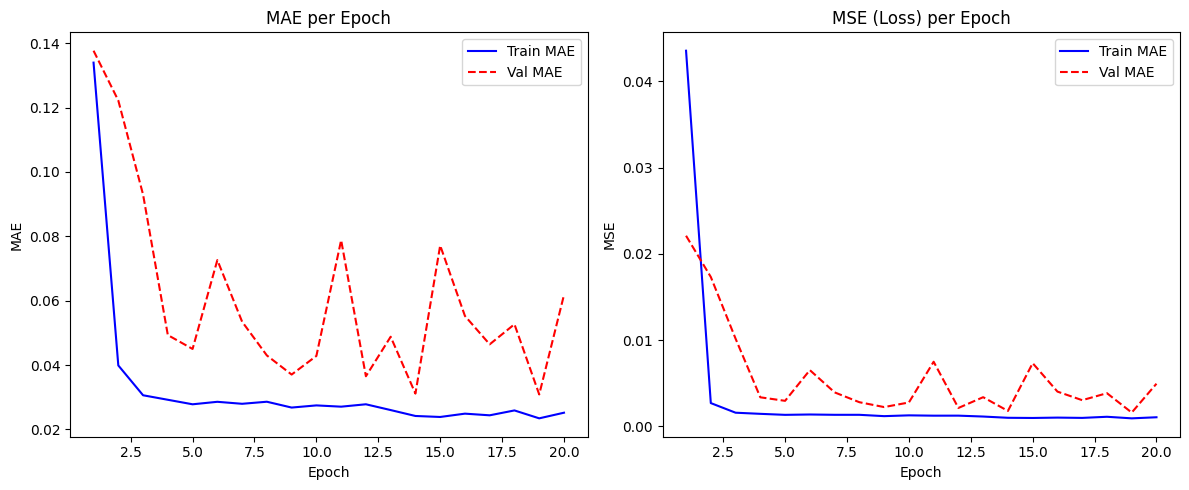

In [39]:
import matplotlib.pyplot as plt


epochs = range(1, 21)

# Plot MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['mae'], 'b-', label='Train MAE')
plt.plot(epochs, history.history['val_mae'], 'r--', label='Val MAE')
plt.title('MAE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot MSE (loss)
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-', label='Train MAE')
plt.plot(epochs, history.history['val_loss'], 'r--', label='Val MAE')
plt.title('MSE (Loss) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

The plots below show how the model's performance evolved during training:

- **Left Plot (MAE)**: The Mean Absolute Error (MAE) measures the average absolute difference between predicted and actual values. Lower values indicate better accuracy.
- **Right Plot (MSE)**: The Mean Squared Error (MSE) is the loss function used during training. It penalizes larger errors more heavily than MAE.

From the chart, we can observe:
- The training error steadily decreases, indicating the model is learning.
- The validation error fluctuates, which might suggest some noise or mild overfitting.

### Final Modelling to deploy

Now we need to use the whole data and fit them into model to predict exactly tommorow SPY Close price

In [21]:
df[feature_cols] = scaler_X.transform(df[feature_cols])
df[target_col] = scaler_y.transform(df[target_col])

In [22]:
X, y = create_lstm_dataset(df, feature, target, window_size)

In [23]:
# Input layer
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Recurrent Layer 1
x = LSTM(128, return_sequences=True)(inputs)

# Reccurent Layer 2
x = LSTM(64, return_sequences=True)(x)

# Reccurent Layer 3
x = LSTM(64, return_sequences=False)(x)

# Output Layer
output = Dense(1)(x)

# Build the model
model2 = Model(inputs=inputs, outputs=output)
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary
model2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 9)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 20, 128)           70656     
                                                                 
 lstm_4 (LSTM)               (None, 20, 64)            49408     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 153,153
Trainable params: 153,153
Non-trainable params: 0
_________________________________________________________________


In [24]:
deploy = model2.fit(
    X, y,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
33/33 [==============================] - 4s 36ms/step - loss: 0.0492 - mae: 0.1537 - val_loss: 0.0338 - val_mae: 0.1714
Epoch 2/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0035 - mae: 0.0452 - val_loss: 0.0235 - val_mae: 0.1422
Epoch 3/20
33/33 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0347 - val_loss: 0.0137 - val_mae: 0.1073
Epoch 4/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0018 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0751
Epoch 5/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0017 - mae: 0.0313 - val_loss: 0.0046 - val_mae: 0.0590
Epoch 6/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0016 - mae: 0.0305 - val_loss: 0.0046 - val_mae: 0.0582
Epoch 7/20
33/33 [==============================] - 0s 14ms/step - loss: 0.0015 - mae: 0.0300 - val_loss: 0.0026 - val_mae: 0.0370
Epoch 8/20
33/33 [==============================] - 0s 13ms/step - loss: 0.0016 - m

In [25]:
last_data = df[-window_size:]
last_data_input = last_data[feature].values
X_input = last_data_input.reshape(1, last_data_input.shape[0], last_data_input.shape[1])

In [26]:
y_pred_scaled = model2.predict(X_input)

1/1 [==============================] - 1s 655ms/step


In [41]:
y_pred_actual = scaler_y.inverse_transform(y_pred_scaled)

print("Predicted Close Price (Next Day / 5 May 2025):", y_pred_actual[0][0])

Predicted Close Price (Next Day / 5 May 2025): 559.2669


### 🧠 Model Used

We implemented a **stacked LSTM model** with the following structure:
- Input: 60 past days of data
- 3 LSTM layers: [128 → 64 → 64 units]
- Final Dense(1) layer for regression
- Trained using `Mean Squared Error (MSE)` loss and `Mean Absolute Error (MAE)` as a metric
- Learning rate: 0.001, optimizer: Adam

We also explored variations such as:
- Bidirectional LSTM (⚠️ Not Recommended for Stock Forecasting)
- Attention mechanism (⚠️ Stock forecasting dont really need old prices unless we predict with seasonality)
- Layer normalization

But all of them doesnt gives any improvement to the model.

---

### ✅ Key Findings

- **Simple LSTM** performs decently for short-term SPY forecasting when trained on properly scaled and temporally encoded data.
- Adding too many **recurrent layers** or attention mechanisms didn't always improve performance.
- **Vanilla LSTM** (with moderate depth) provides a good baseline.

---

### 💡 Future Improvements

Here are some directions to improve or extend the current project:

- 📈 **Try GRU or Transformer-based models** for efficiency and better context awareness
- 🔁 **Add external features**: such as macroeconomic indicators, VIX, or other ETF volumes
- 🧠 **Use ensemble techniques**: like LSTM + XGBoost or multiple models averaged
- 📅 **Multistep forecasting**: predict not just t+1, but t+2, t+3...
- 📊 **Backtesting strategies**: simulate trading strategy based on predicted signals

---

### 🧾 Final Thoughts

This project demonstrates the power and limitations of deep learning on financial time series data. While LSTM can capture temporal dependencies, real-world forecasting still requires careful attention to overfitting, data leakage, and feature engineering. This model provides a strong foundation to iterate upon with more complex data and strategies.
